In [0]:
import gym

import os
import random

from collections import deque

from skimage import io, color, transform

import numpy as np

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

import torchvision


%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
env = gym.make("MsPacman-v0")

In [4]:
NUM_EPISODES = 80000000

EPSILON = 1
EXPERIENCE_REPLAY_CAPACITY = 2000
MINIBATCH_SIZE = 100
LEARNING_RATE = 0.001
ACTION_SIZE = env.action_space.n

EXPLORE = 3000000
IMAGE_DIM = 84

print(ACTION_SIZE)

9


In [0]:
def preprocess_observation(observation):
    """
    Helper function for preprocessing an observation for consumption by our
    deep learning network
    """
    grayscale_observation = color.rgb2gray(observation)
    resized_observation = transform.resize(grayscale_observation, (IMAGE_DIM, IMAGE_DIM))
    return torch.Tensor(resized_observation)

In [0]:
def get_state(dq):
    state = torch.stack(list(dq), dim=0)

    return state

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.size(0)
        return x.view(N, -1)

class DQN(nn.Module):
    def __init__(self):
        # Map input_dim (last 4 frames of the game) to Q scores of all actions
        # in that state
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=(8, 8), padding=(0, 0), stride=(4, 4)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=(4, 4), padding=(0, 0), stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(0, 0)),
            nn.ReLU(inplace=True),
            Flatten(),
            nn.Linear(3136, 512), nn.ReLU(),
            nn.Linear(512, 9)
        )

    def forward(self, x):
        return self.model(x)

In [0]:
class Agent:
    def __init__(self, epsilon, epsilon_decay, alpha, alpha_decay,
                       gamma, minibatch_size, learning_rate):
        self.dqn = DQN().cuda()
        self.target_dqn = DQN().cuda()
        self.target_dqn.load_state_dict(self.dqn.state_dict())

        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.gamma = gamma

        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay

        self.minibatch_size = minibatch_size

        self.optimizer = torch.optim.Adam(self.dqn.parameters(),
                                          lr=learning_rate)

    def get_action(self, state, exploit=False):
        if np.random.uniform() < self.epsilon and not exploit:
            return env.action_space.sample()
        else:
            q_vals = self.target_dqn(state.unsqueeze(0).cuda())
            return torch.argmax(q_vals).item()

    def train(self, replay_memory):
        # Sample a minibatch from replay_memoy
        # Now unpack the state, action, reward values and calculate the
        # better_q approximation

        sample = random.sample(replay_memory, self.minibatch_size)

        alpha = self.alpha
        gamma = self.gamma

        # Unpack data from replay_memory
        states = torch.stack([x[0] for x in sample])
        rewards = torch.cuda.FloatTensor([x[2] for x in sample])
        actions = [x[1] for x in sample]
        next_states = torch.stack([x[-1] for x in sample])

        # Calculate all required Variables for equation
        prev_qs = agent.dqn(states.cuda())[np.arange(100), actions]
        next_qs = agent.target_dqn(next_states.cuda())
        max_next_qs, _ = torch.max(next_qs, 1)

        # Calculate loss
        better_q = (1-alpha)*prev_qs + alpha*(rewards + gamma*max_next_qs)
        loss = ((better_q - prev_qs)**2).sum()

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Slow down learning
        self.alpha *= self.alpha_decay

    def update_target_network(self):
        self.target_dqn.load_state_dict(self.dqn.state_dict())
        self.epsilon *= self.epsilon_decay


agent = Agent(epsilon=1, epsilon_decay=1-1e-5,
              alpha=0.8, alpha_decay=1-1e-5, gamma=0.75,
              minibatch_size=100, learning_rate=0.001)

Ended frame 150 with cumulative reward 20.0


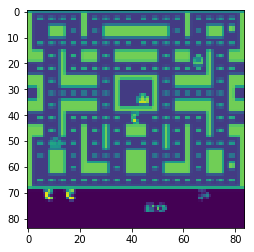

Ended frame 300 with cumulative reward 80.0


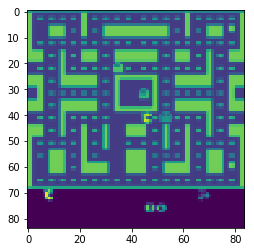

Ended frame 450 with cumulative reward 210.0


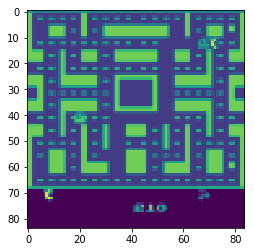

Ended frame 600 with cumulative reward 280.0


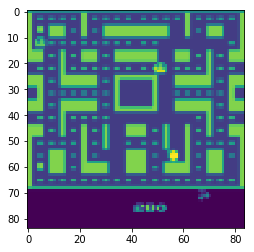

Ended frame 150 with cumulative reward 40.0


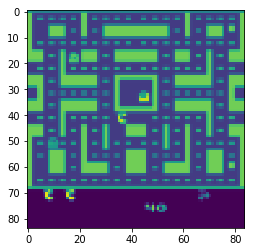

Ended frame 300 with cumulative reward 70.0


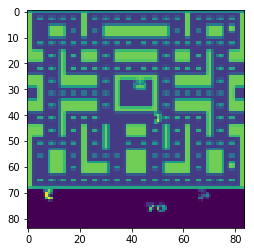

Ended frame 450 with cumulative reward 80.0


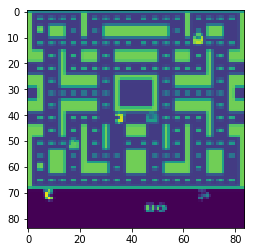

Ended frame 600 with cumulative reward 120.0


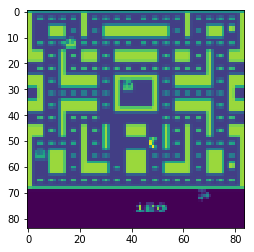

Ended frame 150 with cumulative reward 50.0


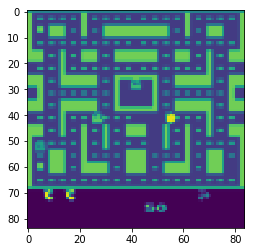

Ended frame 300 with cumulative reward 110.0


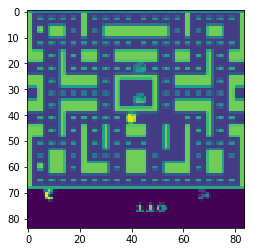

Ended frame 450 with cumulative reward 110.0


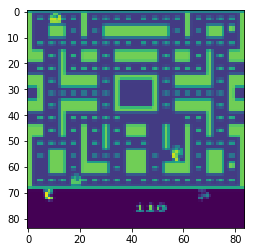

Ended frame 150 with cumulative reward 60.0


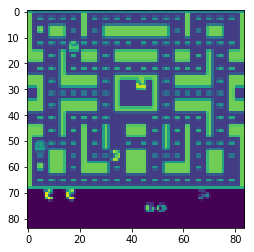

Ended frame 300 with cumulative reward 150.0


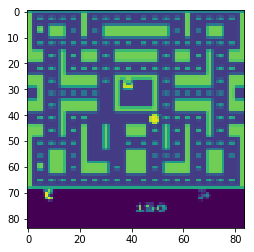

Ended frame 450 with cumulative reward 190.0


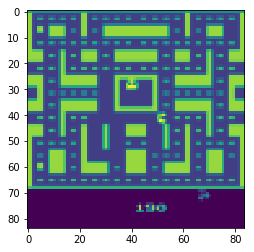

Ended frame 150 with cumulative reward 70.0


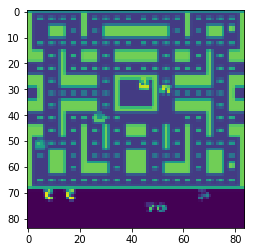

Ended frame 300 with cumulative reward 90.0


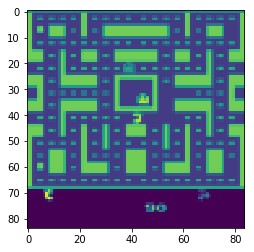

Ended frame 450 with cumulative reward 160.0


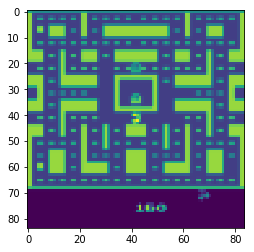

Ended frame 150 with cumulative reward 30.0


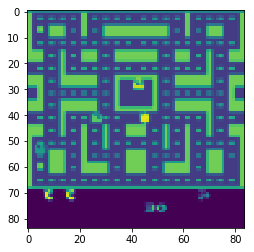

Ended frame 300 with cumulative reward 80.0


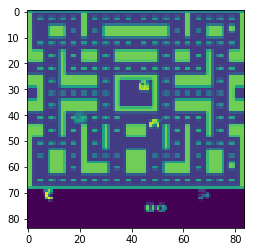

Ended frame 450 with cumulative reward 130.0


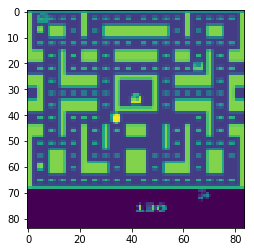

Ended frame 150 with cumulative reward 60.0


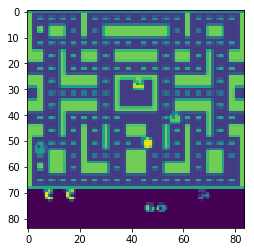

Ended frame 300 with cumulative reward 60.0


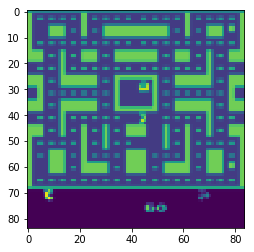

Ended frame 450 with cumulative reward 140.0


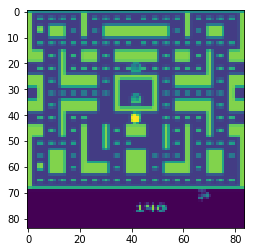

Ended frame 600 with cumulative reward 180.0


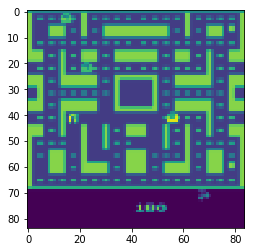

Ended frame 150 with cumulative reward 40.0


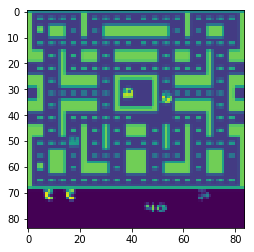

Ended frame 300 with cumulative reward 50.0


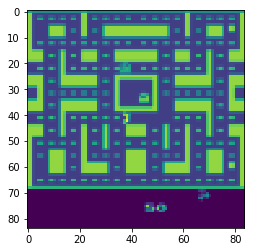

Ended frame 450 with cumulative reward 80.0


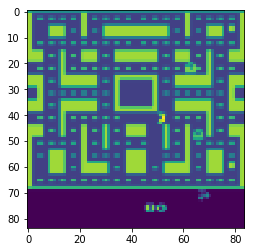

Ended frame 150 with cumulative reward 90.0


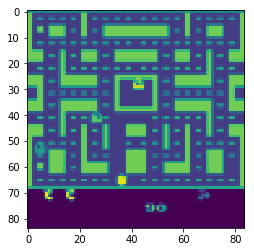

Ended frame 300 with cumulative reward 140.0


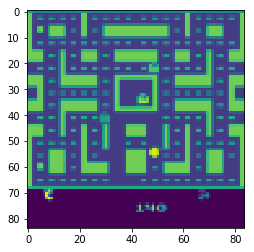

Ended frame 450 with cumulative reward 190.0


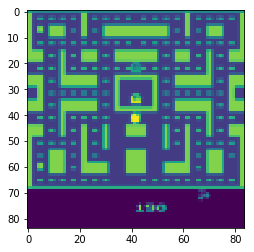

Ended frame 600 with cumulative reward 190.0


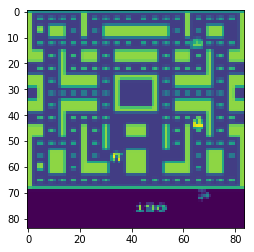

Ended frame 150 with cumulative reward 30.0


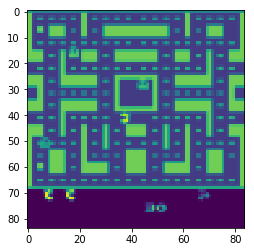

Ended frame 300 with cumulative reward 110.0


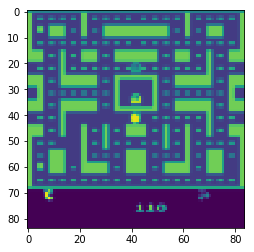

Ended frame 450 with cumulative reward 140.0


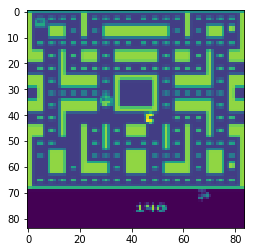

Ended frame 150 with cumulative reward 50.0


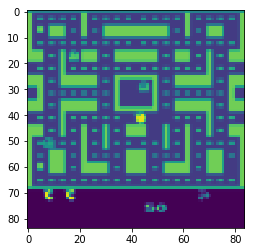

Ended frame 300 with cumulative reward 60.0


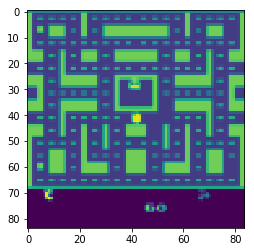

Ended frame 450 with cumulative reward 70.0


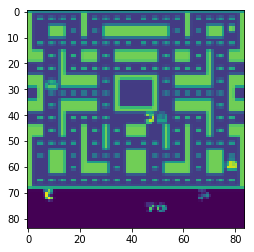

Ended frame 600 with cumulative reward 140.0


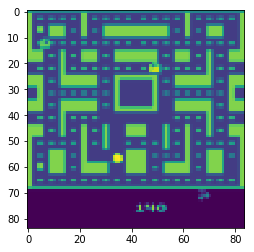

Ended frame 150 with cumulative reward 60.0


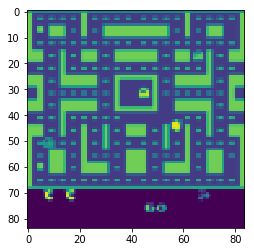

Ended frame 300 with cumulative reward 100.0


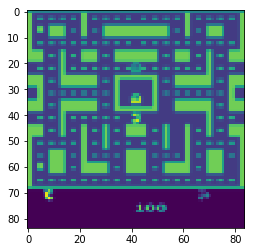

Ended frame 450 with cumulative reward 120.0


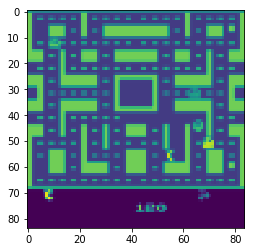

Ended frame 600 with cumulative reward 120.0


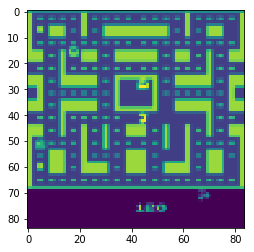

Ended frame 150 with cumulative reward 30.0


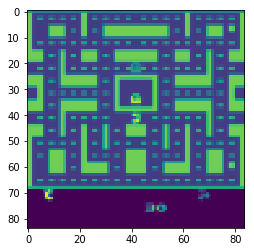

Ended frame 300 with cumulative reward 100.0


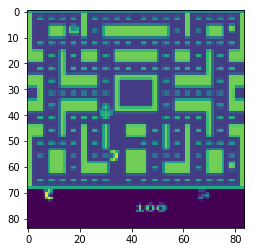

Ended frame 450 with cumulative reward 190.0


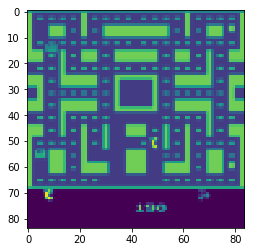

Ended frame 600 with cumulative reward 230.0


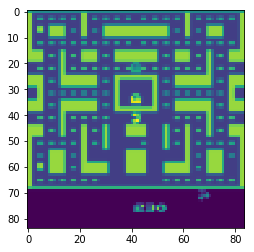

Ended frame 750 with cumulative reward 270.0


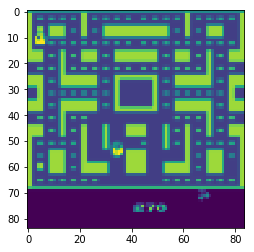

In [0]:
# Episode loop

replay_memory = deque([])
num_frames = 0

for i in range(NUM_EPISODES):
    frame_deque = deque([])
    done = False
    num_frames = 0
    cum_reward = 0
    state = None
    new_state = None

    env.reset()
    while not done:
        # Take action and get information from the environment
        if num_frames == 4:
            action = agent.get_action(state)
        else:
            action = env.action_space.sample()

        xt, rt, done, _ = env.step(agent.get_action(state))
        xt = preprocess_observation(xt)
        cum_reward += rt

        # Add new frame to frame_deque, to make the 4-frame state
        if len(frame_deque) == 4:
            frame_deque.popleft()
        frame_deque.append(xt)

        # Add to replay_memory
        new_state = get_state(frame_deque)
        if len(replay_memory) == 2000:
            replay_memory.popleft()
        if num_frames > 4:
            replay_memory.append((state, action, rt, done, new_state))

        state = new_state

        # Learn from replay_memory
        if len(replay_memory) >= 200:
            agent.train(replay_memory)

        # Debugging information
        num_frames += 1
        if num_frames % 150 == 0:
            print("Ended frame", num_frames, "with cumulative reward",
                  cum_reward, flush=True)
            plt.imshow(xt)
            plt.show()

    # Update target network after each episode
    agent.update_target_network()

    if i % 10 == 0:
        # Save model to disk
        path = F"/content/gdrive/My Drive/MsPacmanDQN.pkl" 
        torch.save(agent.target_dqn.state_dict(), path)